In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python import pywrap_tensorflow

D:\studyINF\data\new\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import h5py
import math

def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- matrix of shape (None ,256 ,256,3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(
        m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def readh5(h5_path , classes):
    f = h5py.File(h5_path, 'r')
    train_images = np.array(f['images'][0:])
    train_labels = np.array(f['labels'][:,0:])
    f.close
    return train_images, train_labels


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [38]:
class Darknet53():
    def __init__(self):
        self.save_list =[]
    def my_conv(self,name,shape, input_data,strides, padding,training_able = True,init_filter = None,init_bias = None):
        """

        :param name: name of filter
        :param shape: shape of filter
        :param input_data: data will be convlutioned
        :param strides: strides of convlution
        :param padding: "valid" or "SAME"
        :return leaky_conv:      result of convlutional layer
        """
        if init_filter is None:
            filter_ = tf.get_variable(name = name, shape = shape, dtype = tf.float32,initializer=tf.contrib.layers.xavier_initializer(uniform=True,seed=None),trainable=training_able)
        else:
            filter_ = tf.get_variable(name = name, dtype = tf.float32,initializer=init_filter,trainable=training_able)
        conv_ = tf.nn.conv2d(input_data, filter_, strides=strides, padding=padding)
        if init_bias is None:
            bias_conv = tf.get_variable("bias_conv"+name[-1], initializer=tf.ones(shape=[shape[-1]]),trainable=training_able)
        else:
            bias_conv = tf.get_variable("bias_conv"+name[-1], initializer=init_bias,trainable=training_able)
        z_ = tf.nn.bias_add(conv_, bias_conv)
        leaky_conv = tf.nn.leaky_relu(z_, 0.1)
        self.save_list.append(filter_)
        self.save_list.append(bias_conv)
        return leaky_conv
    def train(self,training_data, training_label, classes,learning_rate, minibatch_size,num_epochs ):
        input_img = tf.placeholder(dtype = tf.float32, shape = [None ,256,256,3] , name = "input_img")
        input_label = tf.placeholder(dtype = tf.float32,shape =[classes,None],name = "input_label")
        # label 待定
        conv_1 = self.my_conv(name = "filter_1",shape = [3,3,3,32],input_data = input_img, strides = [1,1,1,1], padding ="SAME")
        print("conv_1 shpae is :",conv_1.shape)
        conv_2 = self.my_conv(name = "filter_2",shape = [3,3,32,64],input_data = conv_1, strides = [1,2,2,1],padding ="SAME")
        print("conv_2 shape is:",conv_2.shape)
        conv_3 = self.my_conv(name="filter_3", shape=[1, 1, 64, 32], input_data=conv_2, strides=[1, 1, 1, 1],
                              padding="VALID")
        print("conv_3 shape is:", conv_3.shape)
        conv_4 = self.my_conv(name="filter_4", shape=[3, 3, 32, 64], input_data=conv_3, strides=[1, 1, 1, 1],
                              padding="SAME")
        print("conv_4 shape is:", conv_4.shape)
        resi_1 = conv_2 + conv_4 # 残差项
        conv_5 = self.my_conv(name="filter_5", shape=[3, 3, 64, 128], input_data=resi_1, strides=[1, 2, 2, 1],
                              padding="SAME")
        print("conv_5 shape is:", conv_5.shape) # (None,64,64,128)
        conv_6 = self.my_conv(name = "filter_6", shape =[1,1,128,64], input_data=conv_5, strides=[1,1,1,1],
                              padding="SAME")
        print("conv_6 shape is:",conv_6.shape) # (None,64,64,64)
        conv_7 = self.my_conv(name="filter_7", shape=[3, 3, 64, 128], input_data=conv_6, strides=[1, 1, 1, 1],
                              padding="SAME") # (None,64,64,128)
        print("conv_7 shape is:", conv_7.shape)
        resi_2 = conv_7 +conv_5

        conv_8 =self.my_conv(name ="filter_8",shape=[3,3,128,32],input_data=resi_2,strides=[1,2,2,1],
                             padding="SAME")
        print("conv_8 shape is:",conv_8.shape) # (None,32,32,32)
        conv_9 = self.my_conv(name="filter_9", shape=[3, 3, 32, 16], input_data=conv_8, strides=[1, 2, 2, 1],
                              padding="SAME")
        print("conv_9 shape is:", conv_9.shape)  # (None,16,16,16)
        """
        conv_10 = self.my_conv(name="filter_10", shape=[3, 3, 16, 14], input_data=resi_2, strides=[1, 2, 2, 1],
                              padding="SAME")
        print("conv_10 shape is:", conv_10.shape)  # (None,8,8,14)
        """
        avg_conv9 = tf.nn.avg_pool(conv_9, ksize=(1, 2, 2, 1), strides=[1, 2, 2, 1], padding="VALID")
        flat_conv_9 = tf.layers.flatten(avg_conv9)
        print("flat_conv_9 shape is:",flat_conv_9.shape) # (None,8*8*16)
        trans_flat_conv_9 = tf.transpose(flat_conv_9)

        fc_weight_1 = tf.get_variable("weight_1",shape =[classes,8*8*16],initializer=tf.contrib.layers.xavier_initializer(uniform=True,seed=None))
        fc_bias_1 = tf.get_variable("fc_bias_1",initializer=tf.ones(shape=[classes,1]))
        self.save_list.append(fc_weight_1)
        self.save_list.append(fc_bias_1)
        fc_1 = tf.matmul(fc_weight_1, trans_flat_conv_9)  + fc_bias_1
        print("fc_1 shape is:",fc_1.shape)
        tran_fc_1 = tf.transpose(fc_1)
        input_label_trans = tf.transpose(input_label)

        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=input_label_trans, logits=tran_fc_1))
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        saver = tf.train.Saver(
            self.save_list, max_to_keep=30)
        config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
        with tf.Session(config=config) as sess:

            costs = []
            initzer = tf.global_variables_initializer()
            sess.run(initzer)
            num_minibatches = int(
                training_data.shape[0] / minibatch_size)  # number of minibatches of size minibatch_size in the train set
            seed = 0

            for epoch in range(num_epochs):
                epoch_cost = 0
                seed += 1
                mini_batches = random_mini_batches(training_data, training_label, minibatch_size, seed=seed)
                for batch in mini_batches:
                    _, minibatch_cost = sess.run([optimizer, cost],
                                                 feed_dict={input_img: batch[0] / 255, input_label: batch[1]})
                    epoch_cost += minibatch_cost
                epoch_cost /= num_minibatches
                if epoch % 20 == 0:
                    print(epoch_cost)
                    costs.append(epoch_cost)
                    save_path = saver.save(sess, r"D:\studyINF\AI\2.7code\opencv\for_save\model.ckpt", global_step=epoch)

            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
            correct_predition = tf.equal(tf.argmax(input_label_trans, axis=1), tf.argmax(tran_fc_1, axis=1))
            accuracy = tf.reduce_mean(tf.cast(correct_predition, dtype=tf.float32))
            Accuracy = []

            for i in range(int(training_data.shape[0] / 34)):
                temp_accuracy = accuracy.eval(
                    {input_img: training_data[i * 34:(i + 1) * 34] / 255, input_label: training_label[:, i * 34:(i + 1) * 34]})
                Accuracy.append(temp_accuracy)
                print(temp_accuracy)
        temp_accuracy = np.mean(Accuracy)
        print(temp_accuracy)

    def retrain(self,reader,training_data, training_label, classes,learning_rate, minibatch_size,num_epochs ):
        input_img = tf.placeholder(dtype = tf.float32, shape = [None ,256,256,3] , name = "input_img")
        input_label = tf.placeholder(dtype = tf.float32,shape =[classes,None],name = "input_label")
        # label 待定
        conv_1 = self.my_conv(name = "filter_1",shape = [3,3,3,32],input_data = input_img, strides = [1,1,1,1], padding ="SAME",training_able=False ,init_filter = reader.get_tensor("filter_1"),init_bias = reader.get_tensor("bias_conv1"))
        print("conv_1 shpae is :",conv_1.shape)
        conv_2 = self.my_conv(name = "filter_2",shape = [3,3,32,64],input_data = conv_1, strides = [1,2,2,1],padding ="SAME",training_able=False,init_filter = reader.get_tensor("filter_2"),init_bias = reader.get_tensor("bias_conv2"))
        print("conv_2 shape is:",conv_2.shape)
        conv_3 = self.my_conv(name="filter_3", shape=[1, 1, 64, 32], input_data=conv_2, strides=[1, 1, 1, 1],
                              padding="VALID",training_able=False,init_filter = reader.get_tensor("filter_3"),init_bias = reader.get_tensor("bias_conv3"))
        print("conv_3 shape is:", conv_3.shape)
        conv_4 = self.my_conv(name="filter_4", shape=[3, 3, 32, 64], input_data=conv_3, strides=[1, 1, 1, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_4"),init_bias = reader.get_tensor("bias_conv4"))
        print("conv_4 shape is:", conv_4.shape)
        resi_1 = conv_2 + conv_4 # 残差项
        conv_5 = self.my_conv(name="filter_5", shape=[3, 3, 64, 128], input_data=resi_1, strides=[1, 2, 2, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_5"),init_bias = reader.get_tensor("bias_conv5"))
        print("conv_5 shape is:", conv_5.shape) # (None,64,64,128)
        conv_6 = self.my_conv(name = "filter_6", shape =[1,1,128,64], input_data=conv_5, strides=[1,1,1,1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_6"),init_bias = reader.get_tensor("bias_conv6"))
        print("conv_6 shape is:",conv_6.shape) # (None,64,64,64)
        conv_7 = self.my_conv(name="filter_7", shape=[3, 3, 64, 128], input_data=conv_6, strides=[1, 1, 1, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_7"),init_bias = reader.get_tensor("bias_conv7")) # (None,64,64,128)
        print("conv_7 shape is:", conv_7.shape)
        resi_2 = conv_7 +conv_5

        conv_8 =self.my_conv(name ="filter_8",shape=[3,3,128,32],input_data=resi_2,strides=[1,2,2,1],
                             padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_8"),init_bias = reader.get_tensor("bias_conv8"))
        print("conv_8 shape is:",conv_8.shape) # (None,32,32,32)
        conv_9 = self.my_conv(name="filter_9", shape=[3, 3, 32, 16], input_data=conv_8, strides=[1, 2, 2, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_9"),init_bias = reader.get_tensor("bias_conv9"))
        print("conv_9 shape is:", conv_9.shape)  # (None,16,16,16)
        """
        conv_10 = self.my_conv(name="filter_10", shape=[3, 3, 16, 14], input_data=resi_2, strides=[1, 2, 2, 1],
                              padding="SAME")
        print("conv_10 shape is:", conv_10.shape)  # (None,8,8,14)
        """
        avg_conv9 = tf.nn.avg_pool(conv_9, ksize=(1, 2, 2, 1), strides=[1, 2, 2, 1], padding="VALID")
        flat_conv_9 = tf.layers.flatten(avg_conv9)
        print("flat_conv_9 shape is:",flat_conv_9.shape) # (None,8*8*16)
        trans_flat_conv_9 = tf.transpose(flat_conv_9)

        fc_weight_1 = tf.get_variable("weight_1",shape =[classes,8*8*16],initializer=tf.contrib.layers.xavier_initializer(uniform=True,seed=None))
        fc_bias_1 = tf.get_variable("fc_bias_1",initializer=tf.ones(shape=[classes,1]))
        self.save_list.append(fc_weight_1)
        self.save_list.append(fc_bias_1)
        fc_1 = tf.matmul(fc_weight_1, trans_flat_conv_9) + fc_bias_1
        print("fc_1 shape is:",fc_1.shape)
        #fc_1 = tf.nn.bias_add(temp_,fc_bias_1)
        tran_fc_1 = tf.transpose(fc_1)
        input_label_trans = tf.transpose(input_label)

        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=input_label_trans, logits=tran_fc_1))
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        saver = tf.train.Saver(
            self.save_list, max_to_keep=30)
        config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
        with tf.Session(config=config) as sess:

            costs = []
            initzer = tf.global_variables_initializer()
            sess.run(initzer)
            num_minibatches = int(
                training_data.shape[0] / minibatch_size)  # number of minibatches of size minibatch_size in the train set
            seed = 0

            for epoch in range(num_epochs):
                epoch_cost = 0
                seed += 1
                mini_batches = random_mini_batches(training_data, training_label, minibatch_size, seed=seed)
                for batch in mini_batches:
                    _, minibatch_cost = sess.run([optimizer, cost],
                                                 feed_dict={input_img: batch[0] / 255, input_label: batch[1]})
                    epoch_cost += minibatch_cost
                epoch_cost /= num_minibatches
                if epoch % 20 == 0:
                    print(epoch_cost)
                    costs.append(epoch_cost)
                    save_path = saver.save(sess, r"D:\studyINF\AI\2.7code\opencv\for_save2\model.ckpt", global_step=epoch)

            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
            correct_predition = tf.equal(tf.argmax(input_label_trans, axis=1), tf.argmax(tran_fc_1, axis=1))
            accuracy = tf.reduce_mean(tf.cast(correct_predition, dtype=tf.float32))
            Accuracy = []

            for i in range(int(training_data.shape[0] / 34)):
                temp_accuracy = accuracy.eval(
                    {input_img: training_data[i * 34:(i + 1) * 34] / 255, input_label: training_label[:, i * 34:(i + 1) * 34]})
                Accuracy.append(temp_accuracy)
                print(temp_accuracy)
        temp_accuracy = np.mean(Accuracy)
        print("the accuracy is:",temp_accuracy)
    def prediction(self,reader,sample):
        sample_placeholder = tf.placeholder(name ="sample",shape = [1,256,256,3],dtype = tf.float32)
        conv_1 = self.my_conv(name = "filter_1",shape = [3,3,3,32],input_data = sample_placeholder, strides = [1,1,1,1], padding ="SAME",training_able=False ,init_filter = reader.get_tensor("filter_1"),init_bias = reader.get_tensor("bias_conv1"))
        
        conv_2 = self.my_conv(name = "filter_2",shape = [3,3,32,64],input_data = conv_1, strides = [1,2,2,1],padding ="SAME",training_able=False,init_filter = reader.get_tensor("filter_2"),init_bias = reader.get_tensor("bias_conv2"))
        
        conv_3 = self.my_conv(name="filter_3", shape=[1, 1, 64, 32], input_data=conv_2, strides=[1, 1, 1, 1],
                              padding="VALID",training_able=False,init_filter = reader.get_tensor("filter_3"),init_bias = reader.get_tensor("bias_conv3"))
        
        conv_4 = self.my_conv(name="filter_4", shape=[3, 3, 32, 64], input_data=conv_3, strides=[1, 1, 1, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_4"),init_bias = reader.get_tensor("bias_conv4"))
        
        resi_1 = conv_2 + conv_4 # 残差项
        conv_5 = self.my_conv(name="filter_5", shape=[3, 3, 64, 128], input_data=resi_1, strides=[1, 2, 2, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_5"),init_bias = reader.get_tensor("bias_conv5"))
    
        conv_6 = self.my_conv(name = "filter_6", shape =[1,1,128,64], input_data=conv_5, strides=[1,1,1,1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_6"),init_bias = reader.get_tensor("bias_conv6"))
        
        conv_7 = self.my_conv(name="filter_7", shape=[3, 3, 64, 128], input_data=conv_6, strides=[1, 1, 1, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_7"),init_bias = reader.get_tensor("bias_conv7")) # (None,64,64,128)
        
        resi_2 = conv_7 +conv_5

        conv_8 =self.my_conv(name ="filter_8",shape=[3,3,128,32],input_data=resi_2,strides=[1,2,2,1],
                             padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_8"),init_bias = reader.get_tensor("bias_conv8"))
        
        conv_9 = self.my_conv(name="filter_9", shape=[3, 3, 32, 16], input_data=conv_8, strides=[1, 2, 2, 1],
                              padding="SAME",training_able=False,init_filter = reader.get_tensor("filter_9"),init_bias = reader.get_tensor("bias_conv9"))

        """
        conv_10 = self.my_conv(name="filter_10", shape=[3, 3, 16, 14], input_data=resi_2, strides=[1, 2, 2, 1],
                              padding="SAME")
        print("conv_10 shape is:", conv_10.shape)  # (None,8,8,14)
        """
        avg_conv9 = tf.nn.avg_pool(conv_9, ksize=(1, 2, 2, 1), strides=[1, 2, 2, 1], padding="VALID")
        flat_conv_9 = tf.layers.flatten(avg_conv9)
        trans_flat_conv_9 = tf.transpose(flat_conv_9)
        fc_weight_1 = tf.get_variable("weight_1",initializer=reader.get_tensor("weight_1"))
        fc_bias_1 = tf.get_variable("fc_bias_1",initializer=reader.get_tensor("fc_bias_1"))
        fc_1 = tf.matmul(fc_weight_1, trans_flat_conv_9) + fc_bias_1
        tran_fc_1 = tf.transpose(fc_1)
        number_class =tf.argmax(tran_fc_1, axis=1)
        config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
        with tf.Session(config = config) as sess:
            sess.run(tf.global_variables_initializer())
            num_class = number_class.eval(
                    {sample_placeholder: sample / 255})
        print(num_class[0])

In [4]:
filepath = r"D:\studyINF\AI\2.7code\opencv\train2.h5"
train_images, train_labels = readh5(filepath,classes=4)
train_labels = convert_to_one_hot(train_labels.astype(np.int8), 4)
print(train_images.shape)
print(train_labels.shape)

(272, 256, 256, 3)
(4, 272)


conv_1 shpae is : (?, 256, 256, 32)
conv_2 shape is: (?, 128, 128, 64)
conv_3 shape is: (?, 128, 128, 32)
conv_4 shape is: (?, 128, 128, 64)
conv_5 shape is: (?, 64, 64, 128)
conv_6 shape is: (?, 64, 64, 64)
conv_7 shape is: (?, 64, 64, 128)
conv_8 shape is: (?, 32, 32, 32)
conv_9 shape is: (?, 16, 16, 16)
flat_conv_9 shape is: (?, 1024)
2.6436457335948944
0.24218799825757742
0.10300221224315464
0.05932038486935198
0.02117580416961573
0.010355896069086157


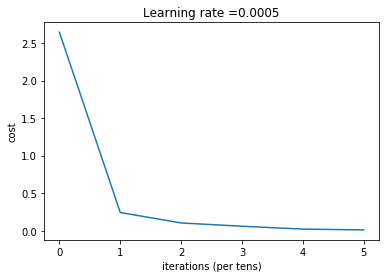

nan


D:\studyINF\data\new\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\studyINF\data\new\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
one = Darknet53()
tf.reset_default_graph()
one.train(train_images,train_labels,classes = 4,learning_rate =0.0005,num_epochs = 101,minibatch_size=34)

In [23]:
reader = pywrap_tensorflow.NewCheckpointReader(r'D:\studyINF\AI\2.7code\opencv\for_save2\model.ckpt-100')
var_to_shape_map = reader.get_variable_to_shape_map()

In [24]:
var_to_shape_map


{'bias_conv1': [32],
 'bias_conv2': [64],
 'bias_conv3': [32],
 'bias_conv4': [64],
 'bias_conv5': [128],
 'bias_conv6': [64],
 'bias_conv7': [128],
 'bias_conv8': [32],
 'bias_conv9': [16],
 'fc_bias_1': [4, 1],
 'filter_1': [3, 3, 3, 32],
 'filter_2': [3, 3, 32, 64],
 'filter_3': [1, 1, 64, 32],
 'filter_4': [3, 3, 32, 64],
 'filter_5': [3, 3, 64, 128],
 'filter_6': [1, 1, 128, 64],
 'filter_7': [3, 3, 64, 128],
 'filter_8': [3, 3, 128, 32],
 'filter_9': [3, 3, 32, 16],
 'weight_1': [4, 1024]}

conv_1 shpae is : (?, 256, 256, 32)
conv_2 shape is: (?, 128, 128, 64)
conv_3 shape is: (?, 128, 128, 32)
conv_4 shape is: (?, 128, 128, 64)
conv_5 shape is: (?, 64, 64, 128)
conv_6 shape is: (?, 64, 64, 64)
conv_7 shape is: (?, 64, 64, 128)
conv_8 shape is: (?, 32, 32, 32)
conv_9 shape is: (?, 16, 16, 16)
flat_conv_9 shape is: (?, 1024)
fc_1 shape is: (4, ?)
4.975292682647705
0.09792752144858241
0.05098072986584157
0.03363194700796157
0.01787627168232575
0.01227964524878189


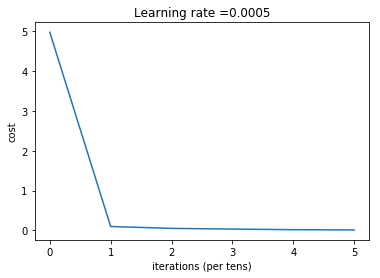

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [20]:
one = Darknet53()
tf.reset_default_graph()
one.retrain(reader,train_images,train_labels,classes = 4,learning_rate =0.0005,num_epochs = 101,minibatch_size=34)

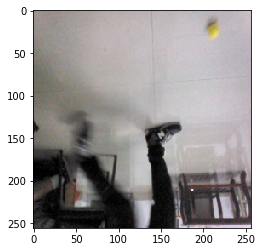

In [41]:
plt.imshow(train_images[100])
plt.show()

In [40]:
one = Darknet53()
tf.reset_default_graph()
one.prediction(reader,train_images[100].reshape(-1,256,256,3))

1
